# Notebook for Experimenting

In [1]:
import os
import json

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns

os.chdir('../src/')

from modules.config import Config
from modules.data import generate_features, load_data
from modules.pipeline_factory import get_pipeline_factory, AdjustedEstimator
from modules.training import train, evaluate

%load_ext autoreload
%autoreload 2

c:\Users\FLP-13-Rimba\miniconda3\envs\project-mix-design\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FEATURES = [
    "age_days",
    "diameter",
    "height",
    "fas",
    "water",
    "cement",
    "sikacim_kg",
    "fine_aggregate_kg",
    "coarse_aggregate_kg",
    "area"
]

data_path = '../datasets/dataset.csv'
scheme_path = '../datasets/scheme.csv'

dataset = load_data(data_path, scheme_path, random_state=42, split=False)
train_set, test_set = load_data(data_path, scheme_path, random_state=42)

raw_data, df_scheme = load_data(
    dataset_path=data_path, scheme_path=scheme_path, raw=True
)

print(train_set.shape, test_set.shape)

train_set[['no', 'sample_code', 'scheme'] + FEATURES + ['weight']].round(2)

(110, 18) (22, 18)


,no,sample_code,scheme,age_days,diameter,height,fas,water,cement,sikacim_kg,fine_aggregate_kg,coarse_aggregate_kg,area,weight
0,1,a,0,1,150.70,301.40,0.5,205,408,0.00,715,1072,17836.78,225
1,2,b,0,1,150.48,302.10,0.5,205,408,0.00,715,1072,17784.74,225
2,3,c,0,1,151.54,302.45,0.5,205,408,0.00,715,1072,18036.18,220
3,4,d,0,3,148.80,303.10,0.5,205,408,0.00,715,1072,17389.85,410
4,5,e,0,3,148.76,302.40,0.5,205,408,0.00,715,1072,17380.50,380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,127,g,3C,7,150.25,303.50,0.5,164,326,6.52,764,1146,17730.41,505
106,128,h,3C,7,151.25,300.30,0.5,164,326,6.52,764,1146,17967.21,400
107,129,i,3C,7,148.80,300.50,0.5,164,326,6.52,764,1146,17389.85,455
108,131,k,3C,28,149.50,303.00,0.5,164,326,6.52,764,1146,17553.85,430


In [3]:
train_set.scheme.value_counts()

scheme
0       10
1A      10
1B      10
1C      10
2A      10
2B      10
2B-1    10
2C      10
3A      10
3B      10
3C      10
Name: count, dtype: int64

In [4]:
def evaluate_model(df, y_pred, threshold=0.2):
    assert len(df) == len(y_pred)

    result = df.copy()
    result["weight_pred"] = y_pred

    if 'weight' in df:
        y_true = df.weight
        result = result.drop("weight", axis=1)
        result["weight_true"] = y_true
        
        result["error"] = (result["weight_true"] - result["weight_pred"]) / result["weight_true"]
        result["abs_error"] = np.abs(result["error"])
        result["adjusted_error"] = (
            np.abs(result["weight_true"] - result["weight_pred"]) /
            np.abs(result["weight_true"] + result["weight_pred"])
        )
        result["quality"] = result["error"].apply(lambda x: 'good' if x <= threshold else 'bad')

    return result


def get_predictions(dataset, model):
    if isinstance(dataset, pd.DataFrame):
        predictions = dataset.copy()
    elif isinstance(dataset, pd.Series):
        predictions = dataset.to_frame().T
    
    y_pred = model.predict(predictions[model.feature_names_in_])
    return y_pred

# Testing with Trained Model

In [5]:
# load model
model_path_0088 = (
    "mlruns/510787892634627721/e1c21e006eba420ca18acde4f5c36ed3/artifacts/model"
)
model_path_0096 = (
    "mlruns/510787892634627721/3d639aa94677411c84a21216fb90c3ff/artifacts/model"
)
model_path_v6 = (
    "mlruns/430123908258705206/704931b304764d57ab947b44763e39ff/artifacts/model"
)
model_path_v7 = (
    "../models/31f693930f4646c0a2767a9aea2b037d/artifacts/model"
)

model = mlflow.sklearn.load_model(model_path_v7)

config_path = '../configs/config_v7.json'
with open(config_path, 'r') as f:
    config = Config(**json.load(f))

model.feature_names_in_ = config.features

In [6]:
config.features

['age_days',
 'diameter',
 'height',
 'fas',
 'cement',
 'sikacim_kg',
 'fine_aggregate_kg',
 'coarse_aggregate_kg']

In [7]:
# prepare data
X_train, y_train = train_set.drop("weight", axis=1), train_set.weight
X_test, y_test = test_set.drop("weight", axis=1), test_set.weight

# analyze result
y_pred = get_predictions(dataset, model)
predictions = evaluate_model(dataset, y_pred)

num_good = predictions[predictions["quality"] == "good"].shape[0]
num_bad = predictions[predictions["quality"] == "bad"].shape[0]

# model.fit(X_train[config.features], y_train)

# X_ = X_train[model.feature_names_in_]
# y_ = y_train
X_ = X_test[model.feature_names_in_]
y_ = y_test

if isinstance(model, AdjustedEstimator):
    old_multiplier = model.multiplier
    # model.multiplier = 1.2
    met = evaluate(model, X_, y_)
    for k, v in met.items():
        if isinstance(v, np.int64):
            met[k] = int(v)
    print(json.dumps(met, indent=4))
    model.multiplier = old_multiplier
else:
    met = evaluate(model, X_, y_)
    print(json.dumps(met, indent=4))

{
    "avg_ape": 0.09657936814416336,
    "max_ape": 0.24847409008203508,
    "p90_ape": 0.17430113959775154,
    "p95_ape": 0.20762886619383403,
    "avg_sape": 0.048376128460633945,
    "max_sape": 0.11050787339647287,
    "p90_sape": 0.0946622024417421,
    "p95_sape": 0.09561697264768657,
    "num_underestimate": 12
}


In [8]:
model.multiplier, model.estimator.weights

(1.08, [0.9, 0.09999999999999998])

In [9]:
model.estimator.named_estimators_['xgb'].named_steps['regressor'].get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.0747194737803982,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 2,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 72,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'obj': <function modules.objectives.smape_objective

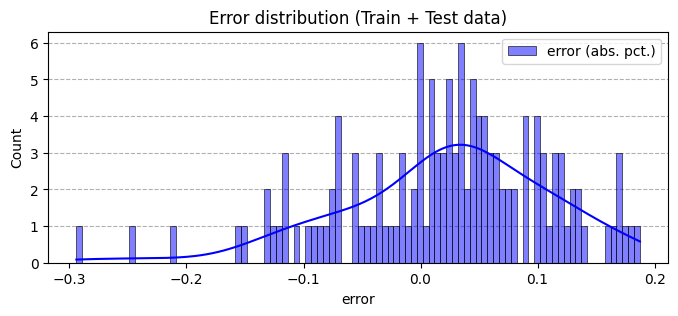

LR coef
age_days               95.916960
diameter               -7.807626
height                -23.197863
fas                   -66.461426
cement                 23.371998
sikacim_kg              7.744861
fine_aggregate_kg       0.218053
coarse_aggregate_kg     1.508600
dtype: float64

XGB feature importance
age_days               0.630308
fas                    0.203934
cement                 0.076545
height                 0.028205
fine_aggregate_kg      0.027907
sikacim_kg             0.024113
diameter               0.008988
coarse_aggregate_kg    0.000000
dtype: float32


In [10]:
# plot error
fig, ax = plt.subplots(figsize=(8, 3))
sns.histplot(
    predictions,
    x="error",
    binwidth=0.005,
    kde=True,
    ax=ax,
    color="blue",
    alpha=0.5,
    label="error (abs. pct.)",
)

ax.set_title("Error distribution (Train + Test data)")
ax.legend()
ax.grid(linestyle='--', axis='y')
ax.set_axisbelow(True)
plt.show()

imp = model.estimator.named_estimators_['xgb']
imp = imp.named_steps['regressor'].feature_importances_
feature_importance = pd.Series(imp, index=model.feature_names_in_)

coef = model.estimator.named_estimators_['sgd']
coef = coef.named_steps['regressor'].coef_
coef = pd.Series(coef, index=model.feature_names_in_,)
print('LR coef')
print(coef)

print('\nXGB feature importance')
print(feature_importance.sort_values(ascending=False))

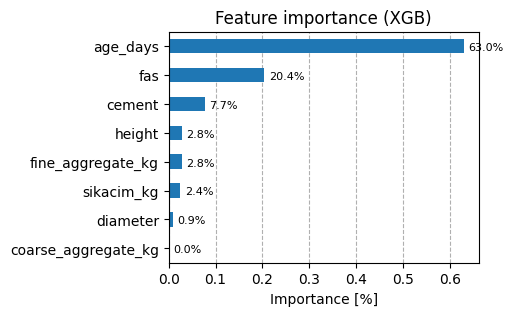

In [11]:
feature_importance.sort_values().plot(kind='barh', figsize=(4, 3))
plt.title('Feature importance (XGB)')
plt.xlabel('Importance [%]')
plt.grid(linestyle='--', axis='x')
plt.gca().set_axisbelow(True)

for i, v in enumerate(feature_importance.sort_values()):
    plt.text(v + 0.01, i - 0.15, f'{v:.1%}', color='black', fontsize=8)

plt.show()

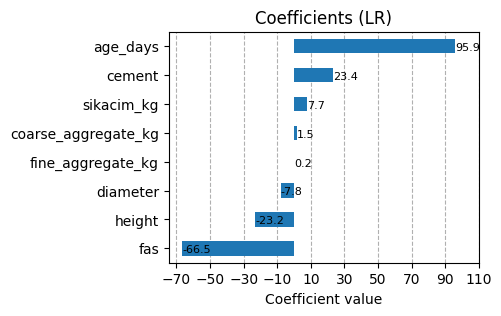

In [12]:
coef.sort_values().plot(kind='barh', figsize=(4, 3))
plt.title('Coefficients (LR)')
plt.xlabel('Coefficient value')
plt.xticks(np.arange(-70, 120, 20))
plt.grid(linestyle='--', axis='x')
plt.gca().set_axisbelow(True)

for i, v in enumerate(coef.sort_values()):
    plt.text(v + 0.01, i - 0.15, f'{v:.1f}', color='black', fontsize=8)

plt.show()

In [13]:
if isinstance(model, AdjustedEstimator):
    cols_to_select = [
        "scheme",
        "sample_code",
        "weight_true",
        "weight_pred",
        "error",
        "adjusted_error",
        "quality",
        "split"
    ]

    mul = model.multiplier
    # mul = 1.2
    y_pred = get_predictions(dataset, model)
    y_pred = y_pred * mul / model.multiplier
    predictions = evaluate_model(dataset, y_pred)
    
    num_good = predictions[predictions["quality"] == "good"].shape[0]
    num_bad = predictions[predictions["quality"] == "bad"].shape[0]
    num_underestimated = predictions[predictions.weight_true > predictions.weight_pred].shape[0]
    print(f"good: {num_good}, bad: {num_bad}, underestimated: {num_underestimated}")

    model.multiplier = mul

    met_train = evaluate(model, X_train[model.feature_names_in_], y_train)
    met_test = evaluate(model, X_test[model.feature_names_in_], y_test)

    for k, v in met_train.items():
        if isinstance(v, np.int64):
            met_train[k] = int(v)

    for k, v in met_test.items():
        if isinstance(v, np.int64):
            met_test[k] = int(v)

    print('Train metrics:')
    print(json.dumps(met_train, indent=4))
    print('Test metrics:')
    print(json.dumps(met_test, indent=4))

    model.multiplier = old_multiplier

    print(predictions[cols_to_select].sort_values(by="error"))

good: 132, bad: 0, underestimated: 87
Train metrics:
{
    "avg_ape": 0.06750674677068899,
    "max_ape": 0.2941012199084802,
    "p90_ape": 0.12996156788270682,
    "p95_ape": 0.15699258262680357,
    "avg_sape": 0.03438867158120304,
    "max_sape": 0.1281988856272928,
    "p90_sape": 0.06906178578292485,
    "p95_sape": 0.08124220071758252,
    "num_underestimate": 75
}
Test metrics:
{
    "avg_ape": 0.09657936814416336,
    "max_ape": 0.24847409008203508,
    "p90_ape": 0.17430113959775154,
    "p95_ape": 0.20762886619383403,
    "avg_sape": 0.048376128460633945,
    "max_sape": 0.11050787339647287,
    "p90_sape": 0.0946622024417421,
    "p95_sape": 0.09561697264768657,
    "num_underestimate": 12
}
    scheme sample_code  weight_true  weight_pred     error  adjusted_error  \
30      1B           g          360   465.876439 -0.294101        0.128199   
72    2B-1           a          325   405.754079 -0.248474        0.110508   
74    2B-1           c          295   356.763031 -0.2

In [14]:
predictions.groupby('split').agg(
    {
        'abs_error': ['mean', 'std', 'max'],
        'adjusted_error': ['mean', 'std', 'max'],
    }
)

abs_error                     adjusted_error                    
           mean       std       max           mean       std       max
split                                                                 
test   0.096579  0.067646  0.248474       0.048376  0.032889  0.110508
train  0.067507  0.051286  0.294101       0.034389  0.026120  0.128199

# Manual Testing by Model

In [15]:
import warnings
warnings.filterwarnings('ignore')

config = Config(
    **{
        'experiment_name': 'v3',
        'algo': 'nn',
        'n_splits': 5,
        'n_repeats': 10,
        'use_height_as_feature': True,
        'age_days_as_categorical': False,
        'random_state': 42,
        'features': FEATURES
    }
)

params = {
    'activation': 'relu',
    'alpha': 0.03728096423300679,
    'beta_1': 0.07904805314839804,
    'beta_2': 0.0032265959783560057,
    'epsilon': 0.24893504448687376,
    'hidden_layer_sizes': (32,),
    'max_iter': 389,
    'random_state': 42,
    'solver': 'lbfgs'
}

pipeline_factory = get_pipeline_factory(config.algo)(config)

metrics, model = train(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    params=params,
    config=config,
    pipeline_factory=pipeline_factory
)

metrics = pd.Series(metrics)
metrics[['val_avg_avg_ape', 'val_max_max_ape', 'val_avg_avg_sape', 'val_max_max_sape']]

val_avg_avg_ape     0.201758
val_max_max_ape     1.150138
val_avg_avg_sape    0.093809
val_max_max_sape    0.394612
dtype: float64

In [16]:
y_pred = get_predictions(dataset, model)
predictions = evaluate_model(dataset, y_pred)

num_good = predictions[predictions['quality'] == 'good'].shape[0]
num_bad = predictions[predictions['quality'] == 'bad'].shape[0]

print(f'Good: {num_good}, Bad: {num_bad}')

predictions.sort_values(by='error', ascending=False)

Good: 119, Bad: 13


,no,sample_code,scheme,age_days,diameter,height,no_scheme,fas,water,cement,...,fine_aggregate_kg,coarse_aggregate_kg,area,split,weight_pred,weight_true,error,abs_error,adjusted_error,quality
32,33,i,1B,7,149.73,305.00,3,0.502451,205,408,...,715,1072,17607.898681,train,357.706456,535,0.331390,0.331390,0.198602,bad
104,105,i,3A,7,149.00,303.40,9,0.502475,203,404,...,717,1076,17436.624626,train,411.455476,610,0.325483,0.325483,0.194374,bad
31,32,h,1B,7,150.55,304.65,3,0.502451,205,408,...,715,1072,17801.286956,test,347.974435,505,0.310942,0.310942,0.184092,bad
102,103,g,3A,7,150.10,299.40,9,0.502475,203,404,...,717,1076,17695.028475,train,476.590450,690,0.309289,0.309289,0.182934,bad
101,102,f,3A,3,150.00,303.60,9,0.502475,203,404,...,717,1076,17671.458676,test,335.901677,485,0.307419,0.307419,0.181628,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,38,b,1C,1,149.00,301.10,4,0.502451,205,408,...,715,1072,17436.624626,test,374.750731,235,-0.594684,0.594684,0.229193,good
14,15,c,1A,1,150.70,300.50,2,0.502451,205,408,...,715,1072,17836.777136,train,371.690584,225,-0.651958,0.651958,0.245840,good
36,37,a,1C,1,150.15,300.50,4,0.502451,205,408,...,715,1072,17706.819265,train,363.587847,215,-0.691106,0.691106,0.256811,good
12,13,a,1A,1,149.66,302.20,2,0.502451,205,408,...,715,1072,17591.438856,train,356.244300,210,-0.696401,0.696401,0.258271,good


In [17]:
predictions[predictions.quality == 'bad'].sort_values(by='error')

,no,sample_code,scheme,age_days,diameter,height,no_scheme,fas,water,cement,...,fine_aggregate_kg,coarse_aggregate_kg,area,split,weight_pred,weight_true,error,abs_error,adjusted_error,quality
56,57,i,2A,7,149.25,302.20,5,0.497549,203,408,...,716,1073,17495.185876,train,447.838836,560,0.200288,0.200288,0.111289,bad
53,54,f,2A,3,150.35,300.10,5,0.497549,203,408,...,716,1073,17754.021695,test,421.017295,545,0.227491,0.227491,0.128344,bad
42,43,g,1C,7,150.63,303.50,4,0.502451,205,408,...,715,1072,17820.210654,train,361.790804,480,0.246269,0.246269,0.140426,bad
112,113,e,3B,3,150.10,303.00,10,0.501441,174,347,...,752,1127,17695.028475,train,305.235625,405,0.246332,0.246332,0.140467,bad
123,124,d,3C,3,150.55,299.00,11,0.503067,164,326,...,764,1146,17801.286956,train,323.231356,435,0.256939,0.256939,0.147407,bad
54,55,g,2A,7,149.50,303.30,5,0.497549,203,408,...,716,1073,17553.845301,train,418.191543,580,0.278980,0.278980,0.162102,bad
126,127,g,3C,7,150.25,303.50,11,0.503067,164,326,...,764,1146,17730.412626,train,357.319858,505,0.292436,0.292436,0.171259,bad
103,104,h,3A,7,150.50,299.70,9,0.502475,203,404,...,717,1076,17789.464750,train,461.420221,655,0.295542,0.295542,0.173393,bad
101,102,f,3A,3,150.00,303.60,9,0.502475,203,404,...,717,1076,17671.458676,test,335.901677,485,0.307419,0.307419,0.181628,bad
102,103,g,3A,7,150.10,299.40,9,0.502475,203,404,...,717,1076,17695.028475,train,476.590450,690,0.309289,0.309289,0.182934,bad


# Single Predictions

In [18]:
sample = pd.DataFrame(
    [
        {
            'age_days': 7,
            'diameter': 151.25,
            'height': 300.3,
            'scheme': '3C',
        },
        {
            'age_days': 14,
            'diameter': 151.25,
            'height': 300.3,
            'scheme': '3C',
        },
        {
            'age_days': 28,
            'diameter': 151.25,
            'height': 300.3,
            'scheme': '3C',
        },
    ]
)

sample = generate_features(sample, df_scheme)
y_pred = get_predictions(sample, model)

evaluate_model(sample, y_pred, threshold=0.2)

,age_days,diameter,height,scheme,no,fas,water,cement,slump,sikacim_pct,sikacim_kg,fine_aggregate_kg,coarse_aggregate_kg,area,weight_pred
0,7,151.25,300.3,3C,11,0.503067,164,326,10.0,2.0,6.52,764,1146,17967.210172,390.246217
1,14,151.25,300.3,3C,11,0.503067,164,326,10.0,2.0,6.52,764,1146,17967.210172,479.486485
2,28,151.25,300.3,3C,11,0.503067,164,326,10.0,2.0,6.52,764,1146,17967.210172,657.967022


# Generate Predictions

In [19]:
report = pd.read_csv('../datasets/report.csv', sep=';')

cols_to_select = [
    'no',
    'scheme',
    'age_days',
    'diameter',
    'height',
    'water',
    'fas',
    'cement',
    'fine_aggregate_kg',
    'coarse_aggregate_kg',
    'sikacim_kg',
    'load_prediction'
]

report_full = generate_features(report, df_scheme)
report_full['load_prediction'] = get_predictions(report_full, model)
report_full = report_full[cols_to_select]

report_full = report_full.rename(
    columns={
        'scheme': 'Skema',
        'age_days': 'Umur (Hari)',
        'diameter': 'Diameter (mm)',
        'height': 'Tinggi (mm)',
        'water': 'Kebutuhan air (kg)',
        'fas': 'fas',
        'cement': 'Kebutuhan semen (kg)',
        'fine_aggregate_kg': 'Kebutuhan agregat halus (kg)',
        'coarse_aggregate_kg': 'Kebutuhan agregat kasar (kg)',
        'sikacim_kg': 'Kebutuhan sikacim (kg)',
        'load_prediction': 'Prediksi (kN)'
    }
)

report_full.round(2)

,no,Skema,Umur (Hari),Diameter (mm),Tinggi (mm),Kebutuhan air (kg),fas,Kebutuhan semen (kg),Kebutuhan agregat halus (kg),Kebutuhan agregat kasar (kg),Kebutuhan sikacim (kg),Prediksi (kN)
0,1,0,1,150,300,205,0.50,408,715,1072,0.00,399.89
1,2,0,3,150,300,205,0.50,408,715,1072,0.00,424.84
2,3,0,7,150,300,205,0.50,408,715,1072,0.00,474.72
3,4,0,14,150,300,205,0.50,408,715,1072,0.00,562.02
4,5,0,28,150,300,205,0.50,408,715,1072,0.00,736.62
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,6B,1,150,300,182,0.48,382,744,1116,3.27,443.24
96,97,6B,3,150,300,182,0.48,382,744,1116,3.27,468.18
97,98,6B,7,150,300,182,0.48,382,744,1116,3.27,518.07
98,99,6B,14,150,300,182,0.48,382,744,1116,3.27,605.37


In [20]:
sample = X_test.loc[
    [0, 2, 4],
    ['age_days', 'diameter', 'height', 'water', 'cement', 'sikacim_kg', 'fine_aggregate_kg', 'coarse_aggregate_kg']
].reset_index(drop=True)

sample.insert(0, 'sample_no', sample.index)
sample.to_csv('../datasets/sample_input.csv', index=False)

print(y_test.loc[[0, 2, 4]])
sample

0    590
2    620
4    330
Name: weight, dtype: int64


,sample_no,age_days,diameter,height,water,cement,sikacim_kg,fine_aggregate_kg,coarse_aggregate_kg
0,0,28,151.28,302.7,205,408,0.000,715,1072
1,1,28,150.38,305.0,205,408,0.816,715,1072
2,2,3,150.28,300.5,205,408,4.488,715,1072


In [21]:
df_scheme.drop(['slump', 'sikacim_pct'], axis=1)

,no,scheme,fas,water,cement,sikacim_kg,fine_aggregate_kg,coarse_aggregate_kg
0,1,0,0.502451,205,408,0.000,715,1072
1,2,1A,0.502451,205,408,0.816,715,1072
2,3,1B,0.502451,205,408,4.488,715,1072
3,4,1C,0.502451,205,408,8.160,715,1072
4,5,2A,0.497549,203,408,0.816,716,1073
5,6,2B,0.426471,174,408,4.488,727,1091
6,7,2B-1,0.470588,192,408,4.488,727,1091
7,8,2C,0.401961,164,408,8.160,731,1097
8,9,3A,0.502475,203,404,0.808,717,1076
9,10,3B,0.501441,174,347,3.817,752,1127


In [22]:
report_full.to_csv('../datasets/report_full.csv', index=False)

# Slump Regression

In [23]:
df_1 = '''0.50	0.00	8
0.50	0.20	11
0.50	1.10	23
0.50	2.00	22
0.50	0.20	9.5
0.43	1.10	4.5
0.47	1.10	10
0.40	2.00	10
0.50	0.20	9.5
0.50	1.10	11
0.50	2.00	10'''.split('\n')

df_2 = '''0.50	205	0.00	8
0.50	205	0.82	11
0.50	205	4.49	23
0.50	205	8.16	22
0.50	203	0.82	9.5
0.43	174	4.49	4.5
0.47	192	4.49	10
0.40	164	8.16	10
0.50	203	0.81	9.5
0.50	174	3.81	11
0.50	164	6.53	10'''.split('\n')

df_1 = pd.DataFrame([list(map(float, x.split('\t'))) for x in df_1], columns=['fas', 'pct_sikacim', 'slump'])
df_2 = pd.DataFrame([list(map(float, x.split('\t'))) for x in df_2], columns=['fas', 'water', 'pct_sikacim', 'slump'])
df_2

,fas,water,pct_sikacim,slump
0,0.50,205.0,0.00,8.0
1,0.50,205.0,0.82,11.0
2,0.50,205.0,4.49,23.0
3,0.50,205.0,8.16,22.0
4,0.50,203.0,0.82,9.5
5,0.43,174.0,4.49,4.5
6,0.47,192.0,4.49,10.0
7,0.40,164.0,8.16,10.0
8,0.50,203.0,0.81,9.5
9,0.50,174.0,3.81,11.0


In [42]:
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

X1 = df_1.loc[:, ['fas', 'pct_sikacim']]
X2 = df_2.loc[:, ['fas', 'water', 'pct_sikacim']]

y1 = df_1.loc[:, ['slump']].values
y2 = df_2.loc[:, ['slump']].values

X2['fas_log'] = np.log1p(X2.fas)
X2['water_log'] = np.log1p(X2.water)
X2['sikacim_log'] = np.log1p(X2.pct_sikacim)

mu1, std1 = X1.mean(axis=0), X1.std(axis=0)
mu2, std2 = X2.mean(axis=0), X2.std(axis=0)

# X1 = (X1 - mu1) / std1
# X2 = (X2 - mu2) / std2

m1 = LinearRegression(positive=True)
m1.fit(X1, y1)

m2 = LinearRegression(positive=True)
m2.fit(X2, y2)

p1 = m1.predict(X1)
p2 = m2.predict(X2)

print(r2_score(p1, y1))
print(r2_score(p2, y2))
print()

print(np.sqrt(mean_squared_error(p1, y1)))
print(np.sqrt(mean_squared_error(p2, y2)))
print()

print(mean_absolute_percentage_error(p1, y1))
print(mean_absolute_percentage_error(p2, y2))
print()

print(np.hstack([y2, p2]).round(2))

-0.36401919659863413
0.812305938125146

4.088237031655453
2.139559162139062

0.23377313459886032
0.1525861016282339

[[ 8.    7.59]
 [11.   10.65]
 [23.   18.38]
 [22.   23.86]
 [ 9.5  10.14]
 [ 4.5   6.44]
 [10.   13.33]
 [10.    7.64]
 [ 9.5  10.11]
 [11.    9.3 ]
 [10.   11.06]]


In [43]:
X2

,fas,water,pct_sikacim,fas_log,water_log,sikacim_log
0,0.50,205.0,0.00,0.405465,5.327876,0.000000
1,0.50,205.0,0.82,0.405465,5.327876,0.598837
2,0.50,205.0,4.49,0.405465,5.327876,1.702928
3,0.50,205.0,8.16,0.405465,5.327876,2.214846
4,0.50,203.0,0.82,0.405465,5.318120,0.598837
5,0.43,174.0,4.49,0.357674,5.164786,1.702928
6,0.47,192.0,4.49,0.385262,5.262690,1.702928
7,0.40,164.0,8.16,0.336472,5.105945,2.214846
8,0.50,203.0,0.81,0.405465,5.318120,0.593327
9,0.50,174.0,3.81,0.405465,5.164786,1.570697


In [44]:
m2.coef_ @ X2.iloc[0].values + m2.intercept_

for i, a in enumerate(m2.coef_.ravel()):
    if 'log' in X2.columns[i]:
        col = f"log(1 + {X2.columns[i].strip('_log')})"
    else:
        col = X2.columns[i]

    print(f'{a:.2f} * {col}', end=' + ')

print(f'{m2.intercept_[0]:.2f}')

57.34 * fas + 0.26 * water + 0.96 * pct_sikacim + 0.00 * log(1 + fas) + 0.00 * log(1 + water) + 3.79 * log(1 + sikacim) + -73.48


In [27]:
X1 = np.hstack([X1, np.ones((X1.shape[0], 1))])
X2 = np.hstack([X2, np.ones((X2.shape[0], 1))])

a1 = np.linalg.inv(X1.T @ X1) @ X1.T @ y1
a2 = np.linalg.inv(X2.T @ X2) @ X2.T @ y2
a1, a2

p1 = X1 @ a1
p2 = X2 @ a2

print(r2_score(p1, y1))
print(r2_score(p2, y2))

-0.36401919659848425
0.9437130456633083


In [28]:
print(np.sqrt(mean_squared_error(p1, y1)))
print(np.sqrt(mean_squared_error(p2, y2)))

4.088237031655455
1.2424080103793205


In [29]:
print(np.sqrt(mean_absolute_percentage_error(p1, y1)))
print(np.sqrt(mean_absolute_percentage_error(p2, y2)))

0.48350091478596685
0.30039295102234964


In [30]:
# print(np.hstack([y1, p1]))
print(np.hstack([y2, p2]))

[[ 8.          5.91132575]
 [11.         11.76491855]
 [23.         20.60305444]
 [22.         22.91843839]
 [ 9.5        11.06960626]
 [ 4.5         4.41406773]
 [10.         10.0875274 ]
 [10.         10.03389427]
 [ 9.5        11.01797326]
 [11.         10.28857153]
 [10.         10.3906218 ]]


In [31]:
df_2['slump_pred'] = p2.round(2)
df_2

,fas,water,pct_sikacim,slump,slump_pred
0,0.50,205.0,0.00,8.0,5.91
1,0.50,205.0,0.82,11.0,11.76
2,0.50,205.0,4.49,23.0,20.60
3,0.50,205.0,8.16,22.0,22.92
4,0.50,203.0,0.82,9.5,11.07
5,0.43,174.0,4.49,4.5,4.41
6,0.47,192.0,4.49,10.0,10.09
7,0.40,164.0,8.16,10.0,10.03
8,0.50,203.0,0.81,9.5,11.02
9,0.50,174.0,3.81,11.0,10.29


In [32]:
a2

array([[ 8.20163307e+03],
       [ 8.83407244e-01],
       [-9.05546313e-01],
       [-1.18725923e+04],
       [-1.09828104e+02],
       [ 1.10149277e+01],
       [ 1.12306875e+03]])